# Barren Plateaus Data Analysis

## Load Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import ast

data_path = '/home/gbarron/data/bps/'
sns.set_palette('viridis', n_colors=100)

def array_interpret(s: str) -> np.array:
    return np.array(ast.literal_eval(f'[{s}]'))[0]

def interpret_complex(s:str) -> float:
    if '+' in s:
        re, im = s.split('+')
        re = float(re)
        im = im.rstrip(" ")[0:-2]
        im = float(im)
        if abs(im) > 0.0:
            raise ValueError("Non-zero imaginary component!!!")
    else:
        re = float(s)
    return re

In [2]:
""" `df_layerwise` contains information collected during the inner loop (VQE
subroutine) of ADAPT-VQE.
"""

df_layerwise = None

for file_path in glob.glob(data_path+'**/layer_*.csv', recursive=True):
    _, _, _, _, _, ham, num_qubits, pool, seed, layer = file_path.split("/")
    num_qubits = int(num_qubits)
    seed = int(seed)
    layer = int(layer.split("_")[1].split(".")[0])
    
    _df_layerwise = pd.read_csv(
            file_path,
            delimiter=';',
            converters={
                'iter': int,
                ' cost': float,
                ' point': array_interpret,
                ' grad': array_interpret}
        )
    _df_layerwise['num_qubits'] = num_qubits
    _df_layerwise['seed'] = seed
    _df_layerwise['layer'] = layer
    
    if df_layerwise is None:
        df_layerwise = _df_layerwise
    else:
        df_layerwise = pd.concat([df_layerwise, _df_layerwise])
df_layerwise.rename(columns=lambda x: x.lstrip(' '), inplace=True)
df_layerwise.drop('point', inplace=True, axis=1)

In [157]:
""" `df_result` contains information about the final convergence properties
of ADAPT-VQE. This includes information about the success of the ADAPT-VQE
algorithm.

`df_adapt` contains information collected during the outer loop of
ADAPT-VQE, for example gradients computed and operators selected, etc.
"""


df_result = None
df_adapt = None

for exact_file_path in glob.glob(data_path+'**/exact_result.csv', recursive=True):
    _, _, _, _, _, ham, num_qubits, pool, seed, _ = exact_file_path.split("/")
    adapt_file_path = exact_file_path.split('exact')[0] + 'adapt_history.csv'
    num_qubits = int(num_qubits)
    seed = int(seed)
    
    _df_result_1 = pd.read_csv(exact_file_path, delimiter=';', converters={
        ' min_bs': str, ' min_val': interpret_complex})
    _df_result_2 = pd.read_csv(adapt_file_path, delimiter=';')
    _df_result_1.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    _df_result_2.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    
    _df_result_1['num_qubits'] = num_qubits
    _df_result_1['seed'] = seed
    _df_result_1['min_bs'] = _df_result_1['min_bs'].map(lambda bs: bs.rjust(num_qubits, '0'))
    
    _df_adapt = pd.concat([pd.concat([_df_result_1]*len(_df_result_2), ignore_index=True), _df_result_2], axis=1, )
    
    if df_adapt is None:
        df_adapt = _df_adapt
    else:
        df_adapt = pd.concat([df_adapt, _df_adapt])
    
df_adapt.reset_index(inplace=True)
df_adapt.drop(columns='index', inplace=True)
df_adapt = df_adapt[df_adapt['opt_numevals'] != ' nothing']
df_adapt['grads'] = df_adapt['grads'].map(array_interpret)
df_adapt['opt_pars'] = df_adapt['opt_pars'].map(array_interpret)
df_adapt['opt_numevals'] = df_adapt['opt_numevals'].map(int)
df_adapt['norm_c'] = df_adapt['energy'] / df_adapt['min_val']


for name, group in df_adapt.groupby(['num_qubits', 'seed']):
    num_qubits, seed = name
    num_layers = max(group['layer'])
    group = group[group['layer'] == num_layers]
    if df_result is None:
        df_result = group
    else:
        df_result = pd.concat([group, df_result])

## Plots

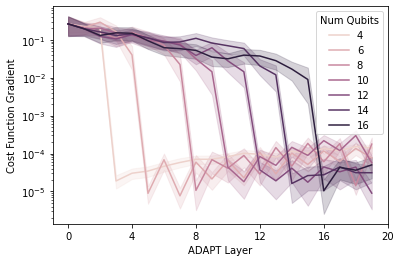

In [12]:
"""This plot shows components of the gradient calculated during
the inner loop (VQE subroutine) of ADAPT-VQE, as a function of the
number of layers and number of qubits.

For each number of qubits, the gradient converges at some number of
layers. Visually, the number of layers required to converge seems to
increase linearly with the number of qubits. This is significant
because it is numerical evidence that (for the max cut problem and
2-local pool), ADAPT-VQE requires `O(n)` layers to converge.
"""
_df_layerwise = df_layerwise.explode('grad')
_df_layerwise.grad = _df_layerwise.grad.astype(float)
_df_layerwise.grad = _df_layerwise.grad.map(abs)
ax = sns.lineplot(data=_df_layerwise, x='layer', y='grad', hue='num_qubits')
ax.set_xlabel("ADAPT Layer")
ax.set_ylabel("Cost Function Gradient")
ax.set_yscale('log')
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='upper right')

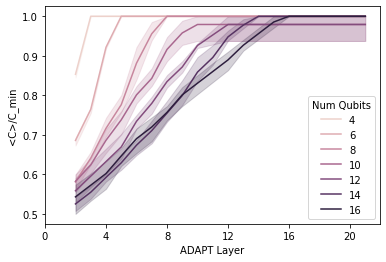

In [161]:
""" This plot demonstrates the success of the ADAPT-VQE algorithm on the
family of max cut Hamiltonians.

Compare with Fig 5 https://arxiv.org/pdf/2004.04197.pdf
"""

ax = sns.lineplot(data=df_adapt, x='layer', y='norm_c', hue='num_qubits')
ax.set_xlabel("ADAPT Layer")
ax.set_ylabel("<C>/C_min")
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='lower right')

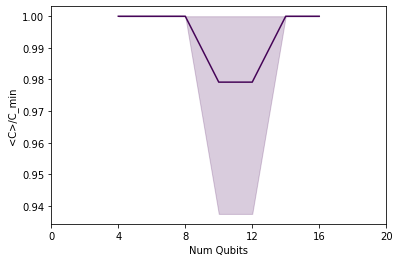

In [164]:
""" This plot demonstrates the success of ADAPT-VQE for the max cut
family of Hamiltonians as a function of the number of qubits. For now
this looks funky since almost all the results converge! This may change
with more sampling and a larger number of qubits.

Compare with Fig 4 https://arxiv.org/pdf/2004.04197.pdf
"""

ax = sns.lineplot(data=df_result, x='num_qubits', y='norm_c')
ax.set_xlabel("Num Qubits")
ax.set_ylabel("<C>/C_min")
ax.set_xticks(np.arange(0, 20+1, step=4));